<a href="https://colab.research.google.com/github/IamShivamJaiswal/sign-board/blob/master/transliteration/Transliteration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Machine Translation with Attention

## Clone the repository

for data

This notebook trains a sequence to sequence (seq2seq) model for Hindi to English word translation. This is an advanced example that assumes some knowledge of sequence to sequence models.

After training the model in this notebook, you will be able to input a english word, such as *"shivam"*, and return the Hindi translation: *"शिवम"*

The translation quality is reasonable for a toy example, but the generated attention plot is perhaps more interesting.

In [1]:
from __future__ import absolute_import, division, print_function

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import os
import io
import time
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import unicodedata
import re
import time

2.5.0


## Preprocessing

1. Add a *start* as `0` and *end* as `1` token to each sentence.
2. Clean the sentences by removing special characters.
3. Create a word index and reverse word index (dictionaries mapping from word → id and id → word).
4. Pad each sentence to a maximum length.

In [2]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = w.replace('-', ' ').replace(',', ' ')
    
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ." 
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    
    w = w.rstrip().strip()
    
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '0' + w + '1'
    return w.split()
  
def preprocess_sentence_hindi(w):
    w = unicode_to_ascii(w.lower().strip())
    w = w.replace('-', ' ').replace(',', ' ')
    
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ." 
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
        
    w = w.rstrip().strip()
    
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '0' + w + '1'
    return w.split()

In [3]:
word = "shivam"
hindi = "शिवम"
print(preprocess_sentence(word))
print(preprocess_sentence_hindi(hindi))

['0shivam1']
['0शिवम1']


In [4]:
import xml.etree.ElementTree as ET
def create_dataset(filename):

    transliterationCorpus = ET.parse(filename).getroot()
    lang1_words = []
    lang2_words = []

    for line in transliterationCorpus:
                wordlist1 = preprocess_sentence(line[0].text) # clean English words.
                wordlist2 = preprocess_sentence_hindi(line[1].text)# clean hindi words.
                
                #to check consistency in the input vs output mapping
                if len(wordlist1) != len(wordlist2):
                    print('Skipping: ', line[0].text, ' - ', line[1].text)
                    continue

                for word in wordlist1:
                    lang1_words.append(word)
                for word in wordlist2:
                    lang2_words.append(word)
    return [lang1_words,lang2_words]

In [5]:
PATH = "./data/"

train_data = create_dataset(PATH+'NEWS2012TrainingEnHi.xml')
test_data = create_dataset(PATH+'NEWS2012TestingEnHi1000.xml')

Skipping:  BUSHNELL'S MUSEUM  -  बुशनेल्स म्युज़ियम
Skipping:  I^DUKAANT  -  इंदुकांत
Skipping:  THE AUSTRALIAN/VOGEL LITERARY AWARD  -  द ऑस्ट्रेलियन/वोगेल लिट्रेरी अवार्ड
Skipping:  PLAZA 66  -  प्लाज़ा 66
Skipping:  Bhaalachan_dr  -  भालचन्द्र
Skipping:  MAN OF THE YEAR/PERSON OF THE YEAR  -  मैन ऑफ द ईयर/पर्सन ऑफ द ईयर
Skipping:  BARHARWA JUNCTION  -  बरहरवा
Skipping:  QUEEN ANNE'S WAR  -  क्वीन एनीज वार
Skipping:  STATE BNK TR  -  स्टेट बैंक ऑफ त्रावणकोर
Skipping:  IN_DRAJEET  -  इन्द्रजीत
Skipping:  SAINT FRANCIS D'ASSISI HIGH SCHOOL  -  सेंट फ्रांसिस ड‍िअस‍ीसी हाई स्कूल
Skipping:  SHU'A  -  शुआ
Skipping:  SOUTH ARLINGTON CHURCH OF CHRIST  -  साउथ अर्लिंग्टन
Skipping:  I^diyaa  -  इंडिया
Skipping:  DAI'EI  -  दैई
Skipping:  ISMA'IL  -  इस्मा'ईल
Skipping:  WOMEN'S LITERATURE PRIZE  -  वुमेन्स लिट्रेचर प्राइज़
Skipping:  KING EDWARD VII  -  किंग एडवर्ड
Skipping:  BRAJEN_DR  -  ब्रजेन्द्र
Skipping:  DIBANG VALLEY  -  दिबंगवैली
Skipping:  LU'LU  -  लु'लु
Skipping:  CHITTAR RESERVOIR-2 

In [6]:
train_data[0][:10],train_data[1][:10]

(['0raasavihaaree1',
  '0deogan',
  'road1',
  '0shatrumardan1',
  '0mahijuba1',
  '0sabine1',
  '0bill',
  'cosby1',
  '0rishta',
  'kagaz'],
 ['0रासविहारी1',
  '0दवगन',
  'रोड1',
  '0शतरमरदन1',
  '0महिजबा1',
  '0सबिन1',
  '0बिल',
  'कॉसबी1',
  '0रिशता',
  'कागज'])

In [7]:
print(len(train_data[0]),len(train_data[1]))

20382 20382


In [8]:
class WordIndex():
  def __init__(self, lang):
    self.lang = lang
    self.word2idx = {}
    self.idx2word = {}
    self.vocab = set()
    
    self.create_index()
    
  def create_index(self):
    for phrase in self.lang:
      for l in phrase:
        self.vocab.update(l)
    
    self.vocab = sorted(self.vocab)
    
    self.word2idx['<pad>'] = 0
    for index, word in enumerate(self.vocab):
      self.word2idx[word] = index + 1
    
    for word, index in self.word2idx.items():
      self.idx2word[index] = word
      

In [9]:
def tokenize(lang):
  index_lang  = WordIndex(lang)
  input_tensor = [[index_lang.word2idx[s] for s in en] for en in lang]
  max_length = max(len(t) for t in input_tensor)
  input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                                 maxlen=max_length,
                                                                 padding='post')
  return input_tensor, index_lang , max_length

In [10]:
def max_length(tensor):
    return max(len(t) for t in tensor)


def load_dataset(pairs):


    # index language using the class defined above    
    targ_lang, inp_lang = pairs[1],pairs[0]
    
    input_tensor, inp_lang_tokenizer ,max_length_inp = tokenize(inp_lang)
    
    target_tensor, targ_lang_tokenizer,max_length_tar = tokenize(targ_lang)
    
    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer,max_length_inp,max_length_tar

In [11]:
input_tensor, target_tensor, inp_lang, targ_lang,max_length_inp, max_length_targ = load_dataset(train_data)

In [12]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.idx2word[t]))

In [13]:
convert(inp_lang,input_tensor[-1])
convert(targ_lang,target_tensor[-1])

6 ----> b
19 ----> o
24 ----> t
12 ----> h
5 ----> a
17 ----> m
3 ----> 1
40 ----> ब
55 ----> ो
34 ----> थ
42 ----> म
5 ----> 1


In [14]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.05)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(19362, 19362, 1020, 1020)

In [15]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 128
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word2idx)+1
vocab_tar_size = len(targ_lang.word2idx)+1

In [16]:
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [17]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([128, 22]), TensorShape([128, 16]))

## Write the encoder and decoder model

Implement an encoder-decoder model with attention which you can read about in the TensorFlow [Neural Machine Translation (seq2seq) tutorial](https://github.com/tensorflow/nmt). This example uses a more recent set of APIs. This notebook implements the [attention equations](https://github.com/tensorflow/nmt#background-on-the-attention-mechanism) from the seq2seq tutorial. The following diagram shows that each input words is assigned a weight by the attention mechanism which is then used by the decoder to predict the next word in the sentence. The below picture and formulas are an example of attention mechanism from [Luong's paper](https://arxiv.org/abs/1508.04025v5). 

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">

The input is put through an encoder model which gives us the encoder output of shape *(batch_size, max_length, hidden_size)* and the encoder hidden state of shape *(batch_size, hidden_size)*.

Here are the equations that are implemented:

<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg" alt="attention equation 1" width="800">

This tutorial uses [Bahdanau attention](https://arxiv.org/pdf/1409.0473.pdf) for the encoder. Let's decide on notation before writing the simplified form:

* FC = Fully connected (dense) layer
* EO = Encoder output
* H = hidden state
* X = input to the decoder

And the pseudo-code:

* `score = FC(tanh(FC(EO) + FC(H)))`
* `attention weights = softmax(score, axis = 1)`. Softmax by default is applied on the last axis but here we want to apply it on the *1st axis*, since the shape of score is *(batch_size, max_length, hidden_size)*. `Max_length` is the length of our input. Since we are trying to assign a weight to each input, softmax should be applied on that axis.
* `context vector = sum(attention weights * EO, axis = 1)`. Same reason as above for choosing axis as 1.
* `embedding output` = The input to the decoder X is passed through an embedding layer.
* `merged vector = concat(embedding output, context vector)`
* This merged vector is then given to the GRU

The shapes of all the vectors at each step have been specified in the comments in the code:

In [18]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [19]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (128, 22, 1024)
Encoder Hidden state shape: (batch size, units) (128, 1024)


In [20]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [21]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (128, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (128, 22, 1)


In [22]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)


    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [23]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((128, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (128, 60)


## Define the optimizer and the loss function

In [24]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask*1.5

  return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)

In [25]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## Training

1. Pass the *input* through the *encoder* which return *encoder output* and the *encoder hidden state*.
2. The encoder output, encoder hidden state and the decoder input (which is the *start token*) is passed to the decoder.
3. The decoder returns the *predictions* and the *decoder hidden state*.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Use *teacher forcing* to decide the next input to the decoder.
6. *Teacher forcing* is the technique where the *target word* is passed as the *next input* to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [26]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word2idx['0']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [27]:
EPOCHS = 30

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.8889
Epoch 1 Batch 100 Loss 1.3943
Epoch 1 Loss 1.3688
Time taken for 1 epoch 667.6670763492584 sec

Epoch 2 Batch 0 Loss 1.1618
Epoch 2 Batch 100 Loss 0.5230
Epoch 2 Loss 0.6535
Time taken for 1 epoch 653.8194727897644 sec

Epoch 3 Batch 0 Loss 0.3558
Epoch 3 Batch 100 Loss 0.2820
Epoch 3 Loss 0.3176
Time taken for 1 epoch 653.4946613311768 sec

Epoch 4 Batch 0 Loss 0.3438
Epoch 4 Batch 100 Loss 0.2752
Epoch 4 Loss 0.2386
Time taken for 1 epoch 650.1300601959229 sec

Epoch 5 Batch 0 Loss 0.2078
Epoch 5 Batch 100 Loss 0.1931
Epoch 5 Loss 0.1970
Time taken for 1 epoch 649.8927059173584 sec

Epoch 6 Batch 0 Loss 0.1664
Epoch 6 Batch 100 Loss 0.1974
Epoch 6 Loss 0.1671
Time taken for 1 epoch 648.9172868728638 sec

Epoch 7 Batch 0 Loss 0.1466
Epoch 7 Batch 100 Loss 0.1680
Epoch 7 Loss 0.1526
Time taken for 1 epoch 648.5707542896271 sec

Epoch 8 Batch 0 Loss 0.1052
Epoch 8 Batch 100 Loss 0.1473
Epoch 8 Loss 0.1310
Time taken for 1 epoch 647.6310544013977 sec

Epoch 9 

## Translitrate

* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*.

Note: The encoder output is calculated only once for one input.

In [28]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)[0]

    inputs = [inp_lang.word2idx[i] for i in sentence]

    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word2idx['0']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.idx2word[predicted_id] + ' '

        if targ_lang.idx2word[predicted_id] == '1':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [29]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [30]:
def translitrate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence[1:-1]))
    print('Predicted translation: {}'.format(''.join(result.split(' '))[:-1]))

    attention_plot = attention_plot[:len(result.split(' ')), :len(list(sentence))]
    plot_attention(attention_plot, list(sentence), result.split(' '))
    

## Restore the latest checkpoint and test

In [31]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: you
Predicted translation: य


<ipython-input-29-b5aba4b9972d>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-29-b5aba4b9972d>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
/home/anas/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 2351 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anas/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 2351 missing from current font.
  font.set_text(s, 0, flags=flags)


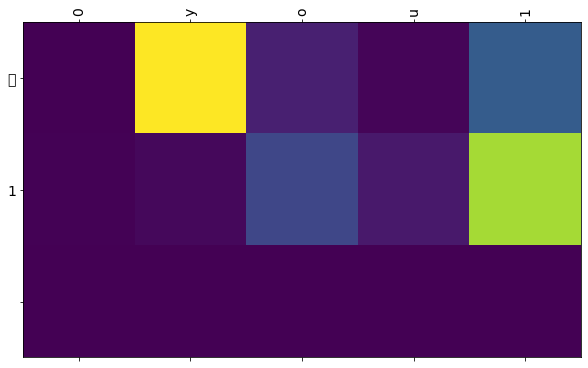

In [32]:
translitrate('you')

Input: anas
Predicted translation: अनस


<ipython-input-29-b5aba4b9972d>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-29-b5aba4b9972d>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
/home/anas/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 2309 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anas/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 2344 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anas/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 2360 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anas/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarni

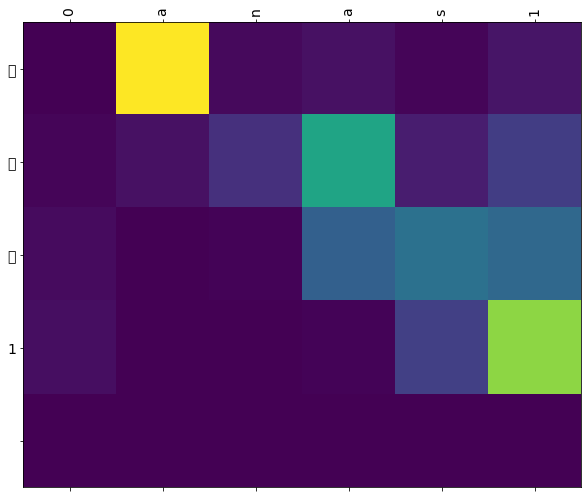

In [33]:
translitrate('anas')

Input: sirsi
Predicted translation: सिरसी


<ipython-input-29-b5aba4b9972d>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-29-b5aba4b9972d>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
/home/anas/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 2367 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anas/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 2352 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anas/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 2368 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anas/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarni

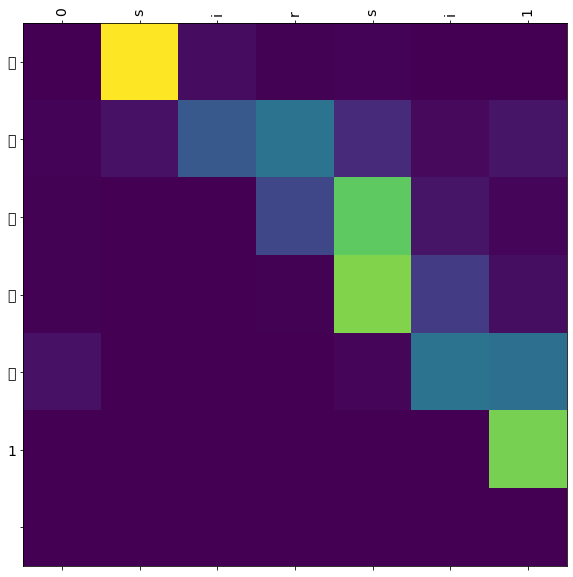

In [34]:
translitrate("sirsi")

## Exact Match Accuracy

In [35]:
def lcs(X, Y): 
    # find the length of the strings 
    m = len(X) 
    n = len(Y) 
  
    # declaring the array for storing the dp values 
    L = [[None]*(n + 1) for i in range(m + 1)] 
  
    """Following steps build L[m + 1][n + 1] in bottom up fashion 
    Note: L[i][j] contains length of LCS of X[0..i-1] 
    and Y[0..j-1]"""
    for i in range(m + 1): 
        for j in range(n + 1): 
            if i == 0 or j == 0 : 
                L[i][j] = 0
            elif X[i-1] == Y[j-1]: 
                L[i][j] = L[i-1][j-1]+1
            else: 
                L[i][j] = max(L[i-1][j], L[i][j-1]) 
  
    # L[m][n] contains the length of LCS of X[0..n-1] & Y[0..m-1] 
    return L[m][n] 

In [36]:
def exactmatch(predict,actual):
  
  #length of Longest Common Subsequence
  l = lcs(predict,actual)
  
  return l / len(actual)

In [37]:
len(test_data[0])

1000

In [38]:
tot = 0.0 
for i in range(len(test_data[0])):
  inputstr , resultstr = test_data[0][i][1:-1],test_data[1][i][1:-1]
  result,_,_ = evaluate(inputstr)
  temppredict = ''.join(result.split(' '))[:-1]
  acc = exactmatch(temppredict,resultstr)
  tot = tot + acc
  print(inputstr,resultstr,temppredict,acc)
print("Average acuracy :",tot/len(test_data[0]))  

aadhi आधी आधी 1.0
aakash आकाश आकाश 1.0
aap आप आप 1.0
aayasha आयशा आयशा 1.0
aayee आई आई 1.0
abduh अबदस अबदह 0.75
aberhart एबरहरट एबरहरट 1.0
abey अबय अबी 0.6666666666666666
abou अब अबोउ 1.0
abri एबरी अबरी 0.75
academy अकडमी एकडमी 0.8
accommodation एकोमडशन एकोमशन 0.8571428571428571
acorn एकोरन एकॉरन 0.8
adams एडमस एडमस 1.0
adgaon अदगाव अदगाव 1.0
adlabs एडलबस अदलाबस 0.6
agro एगरो एगरो 1.0
ahlaad आहलाद आहलाद 1.0
air एअर एयर 0.6666666666666666
aisin एसिन ऐसिन 0.75
ajee अजी अजी 1.0
ajhai अझाई अजहा 0.5
ajith अजीथ अजीथ 1.0
akaram अकरम अकरम 1.0
akele अकल अकली 1.0
akhri आखिरी अखिरी 0.8
akodia अकोडिया आकोदिया 0.7142857142857143
akurdi अकरडी अकरदी 0.8
alas अलास अलस 0.75
albany अलबान अलबनी 0.8
alester एलसटर एलसटर 1.0
alex एलकस एलकस 1.0
alipur अलीपर अलीपर 1.0
alkali अलकली अलकली 1.0
alpesh अलपश अलपश 1.0
amanat अमानत अमानत 1.0
american अमरिकन अमरिकन 1.0
amodini अमोदिनी अमोदीनी 0.8571428571428571
andha अधा अधा 1.0
angel एजल एजल 1.0
anna अनना एना 0.5
anne एनी एनी 1.0
antibody एटीबॉडी एटीबॉडय 0.8571428571

gallants गलटस गलट‍स 1.0
gambhiri गभीरी गभीरी 1.0
ganagapur गनगापर गणगापर 0.8333333333333334
ganegama गनगामा गनगामा 1.0
garam गरम गरम 1.0
garm गरम गारम 1.0
garner गारनर गरनर 0.8
gauss गॉस गौस 0.6666666666666666
gautama गौतम गौतमा 1.0
gauvin गविन गौविन 1.0
geraldene गरलडन जरालडन 0.8
gerita गरीता जरिटा 0.4
germanium जरमनियम जरमनियम 1.0
ghanvatkar घनवटकर घवतकर 0.6666666666666666
ghazali गजली घजली 0.75
ghoda घोडा घोडा 1.0
ghorakhal गोराखल घोरखल 0.6666666666666666
ghule घल घल 1.0
gifford गिफॉरड गिफॉरड 1.0
gladys गलडिस गलडास 0.8
glamorgan गलमॉरगन गलमोरगन 0.8571428571428571
globe गलोब गलोब 1.0
gokhale गोखल गोखल 1.0
gokte गोकट गोकट 1.0
gombe गोब गोब 1.0
goncourt गॉनकोरट गोकॉरट 0.5714285714285714
gorshkov गोरशकॉव गोरशकॉव 1.0
gossaigaon गोसयगज गोससाईगाव 0.6666666666666666
goswami गोसवामी गोसवामी 1.0
govindnagar गोविदनगर गोविदनगर 1.0
graf गरफ गरफ 1.0
gray गर गराय 1.0
grentech गरनटक गरटक 0.8
greville गरविल गरीविल 1.0
gross गरॉस गरॉस 1.0
gudha गधा गधा 1.0
gujarat गजरात गजरात 1.0
gulabi गलाबी गलाबी 1

or ऑर ओर 0.5
orly ऑरली ऑरली 1.0
ormula ऑरमयला ओरमला 0.6666666666666666
osamu ओसाम ओसाम 1.0
overland ओवरलड ओवरलड 1.0
paandu पाड पाड 1.0
painter पटर पटर 1.0
palanca पलानका पलसका 0.6666666666666666
palung पालग पालग 1.0
panama पनामा पनामा 1.0
pantanal पटानल पटानल 1.0
papps पपस पपपस 1.0
par पर पार 1.0
parcel पारसल पारसल 1.0
parineeta परिणिता परिनिता 0.8571428571428571
parkar पारकर पारकर 1.0
parks पारकस पारकस 1.0
parthiv पारथिव पारथिव 1.0
parvat परवत पारवत 1.0
pascoal पासकोल पासकोल 1.0
pasina पसीना पासिना 0.8
pasqual पासकवल पासकवाल 1.0
patnee पतनी पतनी 1.0
patton पटन पटन 1.0
pauls पॉलस पाउलस 0.75
pavarotti पावरोटी पवरोटि 0.7142857142857143
paying पइग पियग 0.6666666666666666
payod पयोद पयोद 1.0
peach पीच पीच 1.0
pearsall पिअरसल परिसल 0.6666666666666666
pearson पीयरसन परियसन 0.6666666666666666
pentamedia पटामीडिया पटामदिया 0.7777777777777778
peoples पीपलस पओपलस 0.8
person परसन परसन 1.0
peters पीटरस पीटरस 1.0
peterson पीटरसन पीटरसन 1.0
philo फिलो फिलो 1.0
phoolvati फलवती फलवती 1.0
photo फोटो फो

williamson विलियमसन विलयमसन 0.875
wishart विशारट विशरट 0.8333333333333334
wisneski विसनसकी विसनसकी 1.0
with विथ विथ 1.0
woh वोह वोह 1.0
wolfman वॉलफमन वॉलफमन 1.0
woolley वल वल 1.0
wuttemberg यटमबरग वटबरग 0.6666666666666666
yadon यादो यादोन 1.0
yashodhar यशोधर यशोधर 1.0
yogeendr योगीदर योगीदर 1.0
zabbar जबबार जबबर 0.8
zaheer जहीर जहीर 1.0
zellweger जलीवगर जललगर 0.6666666666666666
zeppelin जपलिन जपलिन 1.0
zindagi जिदगी जीदगी 0.8
zion जिऑन जिऑन 1.0
Average acuracy : 0.8966408369408363


## Next steps

* [Download a different dataset](http://www.manythings.org/anki/) to experiment with translations, for example, English to German, or English to French.
* Experiment with training on a larger dataset, or using more epochs
